# Result comparaison for Superpixels Entropy

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC
import ERSBasedSegmentation as SPS

import SSGA

512 217 204


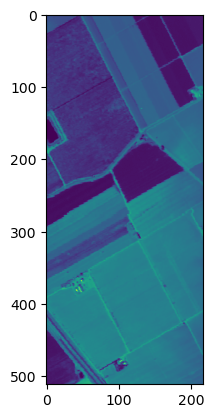

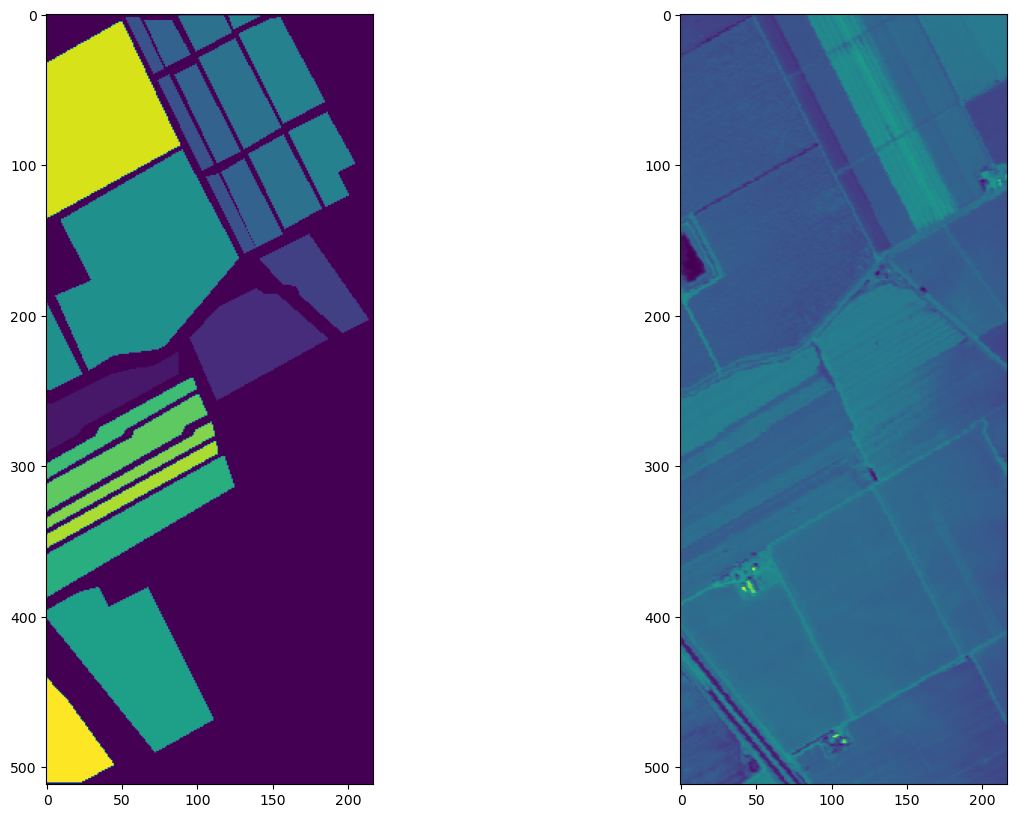

In [2]:
dataset = Data.IndianPines
#dataset = Data.PaviaUniversity
#dataset = Data.PaviaCenter
dataset = Data.SalinasScene

usedDataset = dataset
#usedDataset,_,_ = Data.cropDataset(usedDataset, 200, 200)
N,M,B = usedDataset["shape"]
print(N,M,B)
trainData = Data.standardize_data(usedDataset["data"])

b = np.random.randint(0, B-1)
plt.imshow(trainData[:,:,b])
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

## Compute SPs

In [3]:
RunDataFormat = False
useLambdasModel = True

import json
datasetFolder = "datasets/"
saved_file_name = {
    True: "FormatDataSuperpixels",
    False: "SimFunSuperpixels"
}

complete_save_file_name = datasetFolder + saved_file_name[RunDataFormat]
if useLambdasModel and not RunDataFormat:
    complete_save_file_name += "UsedLambdasModel"
complete_save_file_name +=  usedDataset["name"] +".json"
print(complete_save_file_name)

datasets/SimFunSuperpixelsUsedLambdasModelSalinas Scene.json


In [5]:
Ks = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900]
#Ks = [100, 300, 500, 700, 900, 1100, 1300, 1500]


names = ["basic"] + ["std"] + ["Norm1"] 

ns_component = [0, 3, 10]
names += ["ML F-norm1 "+str(n) for n in ns_component]

#names += ["ML DBI "+str(n) for n in ns_component]
#names += ["ML Dunn "+str(n) for n in ns_component]
#names += ["ML XBI "+str(n) for n in ns_component]

#names += ["ML F-norm2 "+str(n) for n in ns_component]
#names += ["ML F-std-norm1 "+str(n) for n in ns_component]
names += ["ML F-std", "ML F-std²", "ML F-std exp", "ML F-std exp2"]
#names += ["ML F-std-exp"]

names += ["MB F-test sim1"]
names += ["MB stdF-test²"]
names += ["MB comp 3", "MB comp 10"]
MB_ns_component = [2, 5, 10]
#names += ["MB norm1 "+str(n) for n in MB_ns_component]
#names += ["MB perason "+str(n) for n in MB_ns_component]

datas = names
trainData = Data.standardize_data(trainData)

In [6]:
SPsDic = {K:[] for K in Ks}

print("basic")
SPs_dic_i = ERS.find_superpixel(usedDataset["data"], Ks, lambda_coef=1, simFun="average", updateLambda=False)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("standardized average")
SPs_dic_i = ERS.find_superpixel(trainData, Ks, lambda_coef="auto",simFun="average", updateLambda=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("norm1")
SPs_dic_i = ERS.find_superpixel(trainData, Ks, lambda_coef="auto",simFun="norm1", updateLambda=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])


basic
standardized average
norm1


In [7]:
Ks_or = SPS.compute_Ks(N,M)
print("info")
infos = SPS.createMultilevelInfo(trainData, Ks_or)

for n in ns_component:
    print(n)
    # /!\ maybe use SPS.stdFtestnorm1 varFun instead of F-tet
    SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=n, infos=infos)
    for K in Ks:
        SPsDic[K].append(SPs_dic_i[K])
    
print("std")
SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=0, infos=infos,
                                         varFun=SPS.stdFtestnorm1, dist=(1,""))
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("std")
SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=0, infos=infos,
                                         varFun=SPS.stdFtestnorm1, dist=(2,""))
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("std")
SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=0, infos=infos,
                                         varFun=SPS.stdFtestnorm1, dist=("exp",""))
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("std")
SPs_dic_i = SPS.multilevelSPsegmentation(trainData, Ks, n_component=0, infos=infos,
                                         varFun=SPS.stdFtestnorm1, dist=(1,"exp"))
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])


info
0
3
10
std
std
std
std


In [14]:
SPs_or, neighboors_or = infos
Ks.sort(key=lambda x:-x)

In [21]:
group1G = None
group2G = None
TSG = None

In [22]:
from sklearn.decomposition import PCA

def insert_sorted(l, elt):
    _,_,w = elt
    left, right = 0, len(l)
    while left < right:
        mid = (left+right)//2
        if l[mid][2]<w:
            left = mid+1
        else:
            right = mid
    l.insert(left, elt)


varFun = SPS.anovaFtest
dist = ERS.norm1_similarity

def simFun(group1, group2, n_component=3, compare_comp=False):
    if n_component==0:
        return varFun([group1, group2], dist=dist)
    if compare_comp:
        clusters = []
        for group in [group1, group2]:
            TS = np.array([trainData[coor] for coor in group])
            n_ = min(n_component, min(TS.shape))
            pca = PCA(n_components=n_)
            pca.fit_transform(TS)
            clusters.append(pca.components_ + pca.mean_)
        return varFun(clusters, dist=dist)
        
    TS = np.array([trainData[coor] for group in [group1, group2] for coor in group])
    n_ = min(n_component, min(TS.shape))
    pca = PCA(n_components=n_)
    try:
        coeffs = pca.fit_transform(TS)
    except:
        global group1G, group2G, TSG
        group1G = group1
        group2G = group2
        TSG = TS
        print(n_)
        print(TS.shape)
        assert False

    clusters = [[], []]
    for i in range(len(group1)):
        clusters[0].append(coeffs[i])
    for i in range(len(group2)):
        clusters[1].append(coeffs[i+len(group1)])
    clusters = [np.array(cluster) for cluster in clusters]
    return varFun(clusters, dist=dist)


In [23]:
SPs = [SP.copy() for SP in SPs_or]
neighboors:list[set] = [neighboor.copy() for neighboor in neighboors_or]

nb_cc = len(SPs)
existing = [True for _ in range(nb_cc)]
edges = [(u, v, simFun(SPs[u], SPs[v])) for u in range(nb_cc)
            for v in neighboors[u] if u<v]
edges.sort(key=lambda x:x[2])

SPsDic = {K:[] for K in Ks}
for K in Ks:
    print(K)
    print(len(edges))
    while nb_cc > K and len(edges)>0:
        k1,k2,_ = edges.pop(0)
        if existing[k1] and existing[k2]:
            existing[k2] = False
            SPs[k1] += SPs[k2]
            SPs[k2] = None
            neighboors[k1] = neighboors[k1].union(neighboors[k2])
            neighboors[k2] = None

            edges = [(u,v,w) for u,v,w in edges if u!=k1 and v!=k2 and u!=k2 and v!=k1 and existing[u] and existing[v]]
            for v in neighboors[k1]:
                if v!=k1 and existing[v]:
                    insert_sorted(edges, (k1,v, simFun(SPs[k1], SPs[v])))
            
            nb_cc -=1
    SPsDic[K] = [[coor for coor in SP] for i,SP in enumerate(SPs) if existing[i]]


900
9313
3
(162, 204)


AssertionError: 

In [24]:
print(TSG.shape)

(162, 204)


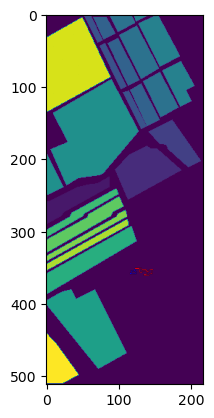

In [34]:
plt.imshow(usedDataset["gt"])
mask = ERS.create_overlay_borders(usedDataset["gt"], [group1G],
                                  color=[255,0,0,200])
plt.imshow(mask)

mask = ERS.create_overlay_borders(usedDataset["gt"], [group2G],
                                  color=[0,0,255, 200])
plt.imshow(mask)
plt.show()

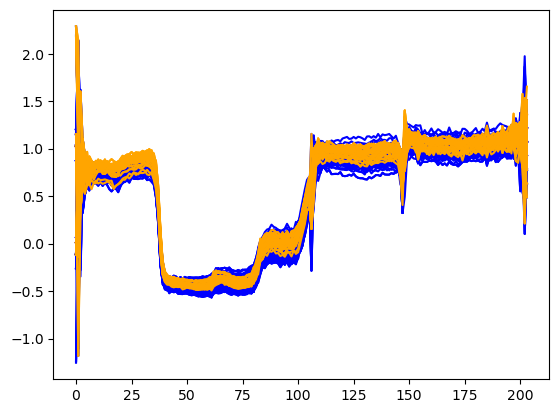

In [41]:
for ts in group1G:
    plt.plot([b for b in range(B)], trainData[ts], "-", color="blue")

for ts in group2G:
    plt.plot([b for b in range(B)], trainData[ts], "-", color="orange")

In [44]:
TS = np.array([trainData[coor] for group in [group1G, group2G] for coor in group])
TS -= TS.mean(axis=0)
TS /= TS.std(axis=0) + 1e-8
pca = PCA(n_components=3)
coeffs = pca.fit_transform(TS)

In [42]:
pca = PCA(n_components=3)
coeffs = pca.fit_transform(TSG)

LinAlgError: SVD did not converge

In [8]:
infos = SPS.computeMergeBasedInfo(trainData, n_component=0)

print("basic")
SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infos)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print("std")
SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infos,
                                        usedVarFun=SPS.stdFtestnorm1,
                                        dist=(2,""))
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])


print(3)
infos = SPS.computeMergeBasedInfo(trainData, n_component=3)
SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infos, n_component=3)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

print(10)
infos = SPS.computeMergeBasedInfo(trainData, n_component=10)
SPs_dic_i = SPS.mergedBasedSegmentation(trainData, Ks, infos=infos, n_component=10)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])

basic
std
3


LinAlgError: SVD did not converge

In [ ]:
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]
else:
    datas = ["average", "norm2", "norm1", "perason"]
    names = ["Average", "Norm2", "Norm1", "Perason"]
    trainData = Data.standardize_data(trainData)
    getLambdas = [LC.getLambdaAverage, LC.getLambdaNorm2, LC.getLambdaNorm1]


FoundLambdaCoeffKey = "DataFormat" if RunDataFormat else "SimilarityFunction"
LambdaCoeffs = Data.FoundLambdaCoeff[FoundLambdaCoeffKey]


if usedDataset["name"] in [Data.IndianPines["name"], Data.PaviaUniversity["name"]]:
    Ks = list(LambdaCoeffs[usedDataset["name"]].keys())
else:
    Ks = [100, 200, 300, 400, 500, 600]

Ks = [100, 300, 500, 700, 900, 1100, 1300] 
    
if len(Ks)==1:
    complete_save_file_name = complete_save_file_name[:len(complete_save_file_name)-5] + str(Ks[0]) + "SP.json"
    print(complete_save_file_name)
Ks.sort(key=lambda x:x)

print(trainData.shape)
print(Ks)

(145, 145, 200)
[100, 300, 500, 700, 900, 1100, 1300]


In [ ]:
def compute_SPs(Ks, save_data=False, find_lambda=True):
    SPsDic = {K:[] for K in Ks}

    if (not RunDataFormat) and useLambdasModel:
        for i,funName in enumerate(datas):
            print("i =", i, "(" + funName + ")")
            SPs_dic_i = ERS.find_superpixel(trainData, Ks,
                                           lambda_coef="auto",
                                           simFun=funName,
                                           updateLambda=True)
            for K in Ks:
                SPsDic[K].append(SPs_dic_i[K])
    
    else:
        SPsDic = {}
        for K in Ks:
            print("K:", K)
            Ps = LC.computePs(K, N, M)

            current_list = []
            for i,data in enumerate(datas):
                print(i, end=" ")
                if RunDataFormat:

                    fun = ERS.create_CSF("average", data)
                    if find_lambda:
                        SPs, coeff = LC.dichotomies_search(data, K, 1, 400, fun, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        SPs = ERS.find_superpixel(data, K,
                                                lambda_coef=LambdaCoeffs[usedDataset["name"]][K][i],
                                                simFun="average")
                else:
                    if find_lambda:
                        fun = ERS.create_CSF(data, trainData)
                        SPs, coeff = LC.dichotomies_search(trainData, K, 1, 400, fun, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        lc = LambdaCoeffs[usedDataset["name"]][K][i]
                        SPs = ERS.find_superpixel(trainData, K,
                                                    lambda_coef=lc,
                                                    simFun=data)
                current_list.append(SPs)
            print()
            SPsDic[K] = current_list


    if save_data:
        json_object = json.dumps(SPsDic)
        with open(complete_save_file_name, "w") as f :
            f.write(json_object)
            f.close()
    return SPsDic


SPsDic = compute_SPs(Ks, save_data=True, find_lambda=False)

i = 0 (average)
i = 1 (norm2)
i = 2 (norm1)
i = 3 (perason)


In [63]:
with open(complete_save_file_name, "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

Ks = list(SPsDic.keys())
Ks.sort()

### Superpixels Classifier

In [ ]:
ClassifierDic:dict[int, list[ERS.SuperpixelClassifier]] = {}
for b in [True, False]:
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

### Visual result

In [ ]:
K = 200
ids = [2, 8, 9, 11,12]
imgs = [usedDataset["gt"]] + [ClassifierDic[False][K].guess_map]
fig, axs = plt.subplots(1, len(ids)+1, figsize=(14,10))

for i,img in enumerate(imgs):
    new_img = img.copy()

    new_img[0,0] = max(usedDataset['labels'])
    axs[i].imshow(new_img)
    axs[i].axis("off")
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

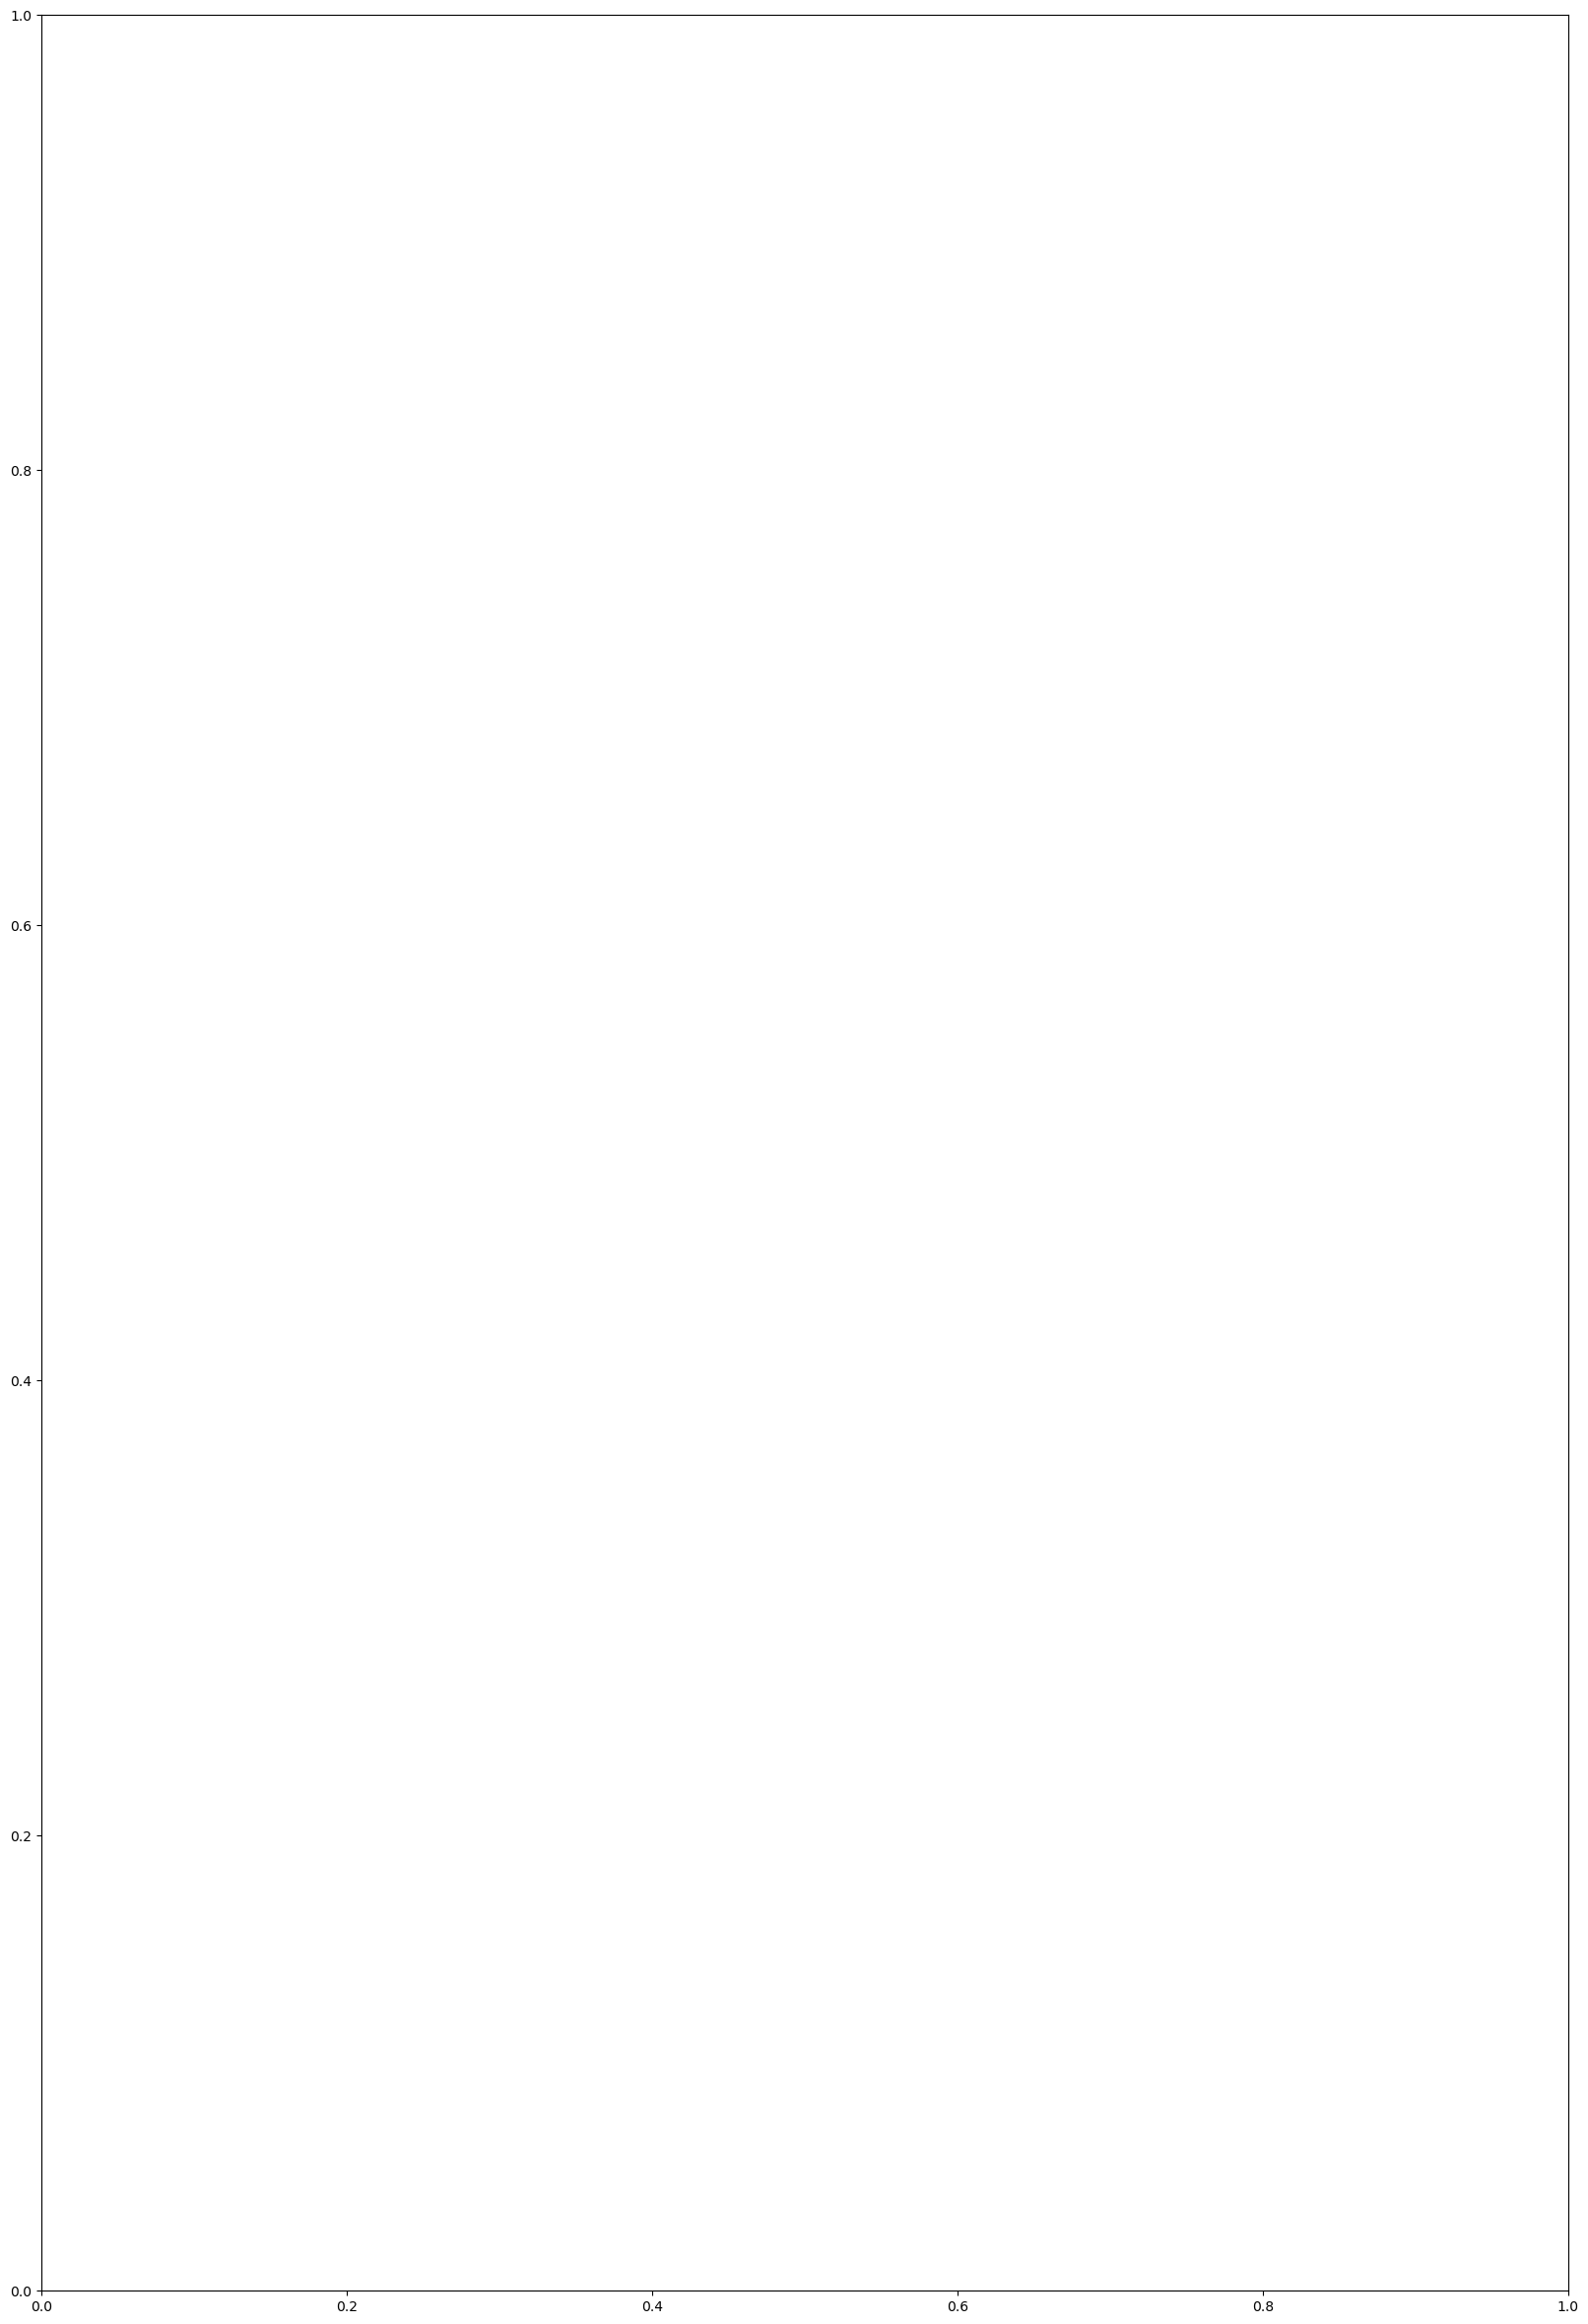

In [10]:
K = 150

fig, axs = plt.subplots(1, len(SPsDic[K]))
fig.set_size_inches(20,30)
for i,SP in enumerate(SPsDic[K]):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]

    imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [name+" prediction" for name in names]


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()

    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [ ]:
size = len(ClassifierDic[True][Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeightedJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
#singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeightedProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

labelsAccuracy = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}
labelsJaccard = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[b][K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"])
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"])
            averageWeightedJaccard[b][K][i] = C.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"])
            #singleClassCounts[b][K][i] = C.singleClassProportion()
            averageWeightedProportions[b][K][i] = C.averageWeightedProportion()
        
            for label in usedDataset["labels"]:
                if label in C.labels:
                    labelsAccuracy[b][label][K][i] = C.labelAccuracy(usedDataset["class"], label)
                    labelsJaccard[b][label][K][i] = C.jaccard(usedDataset["gt"], usedDataset["class"], label)
        

True
False


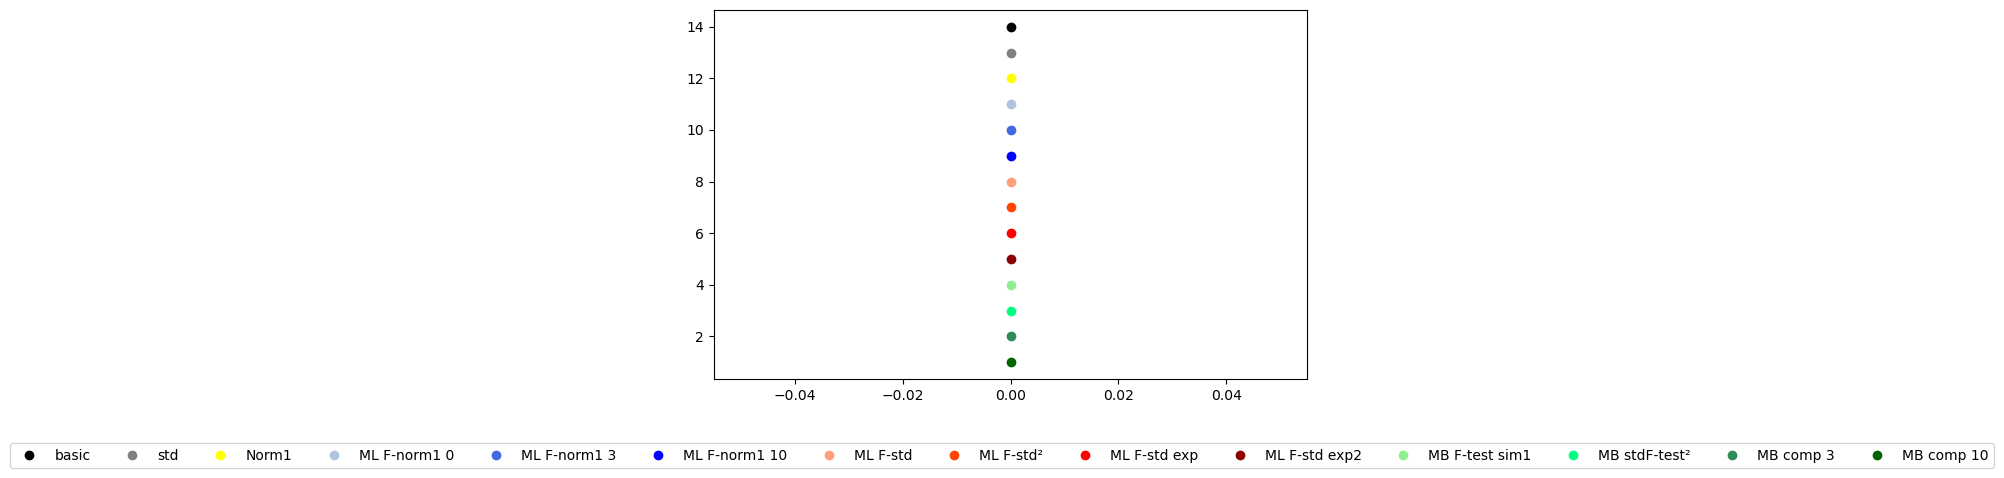

True


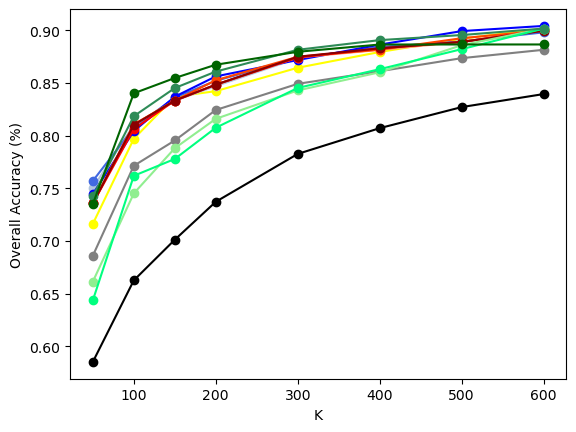

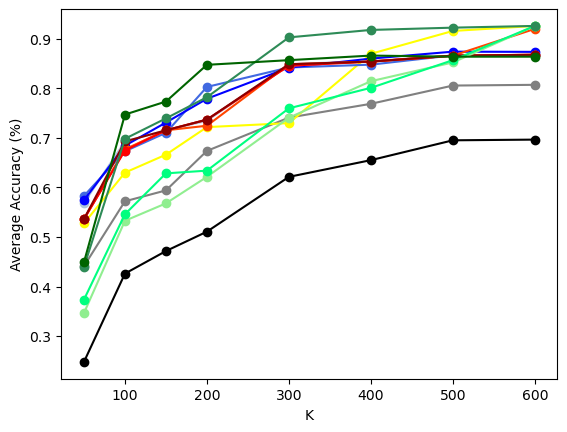

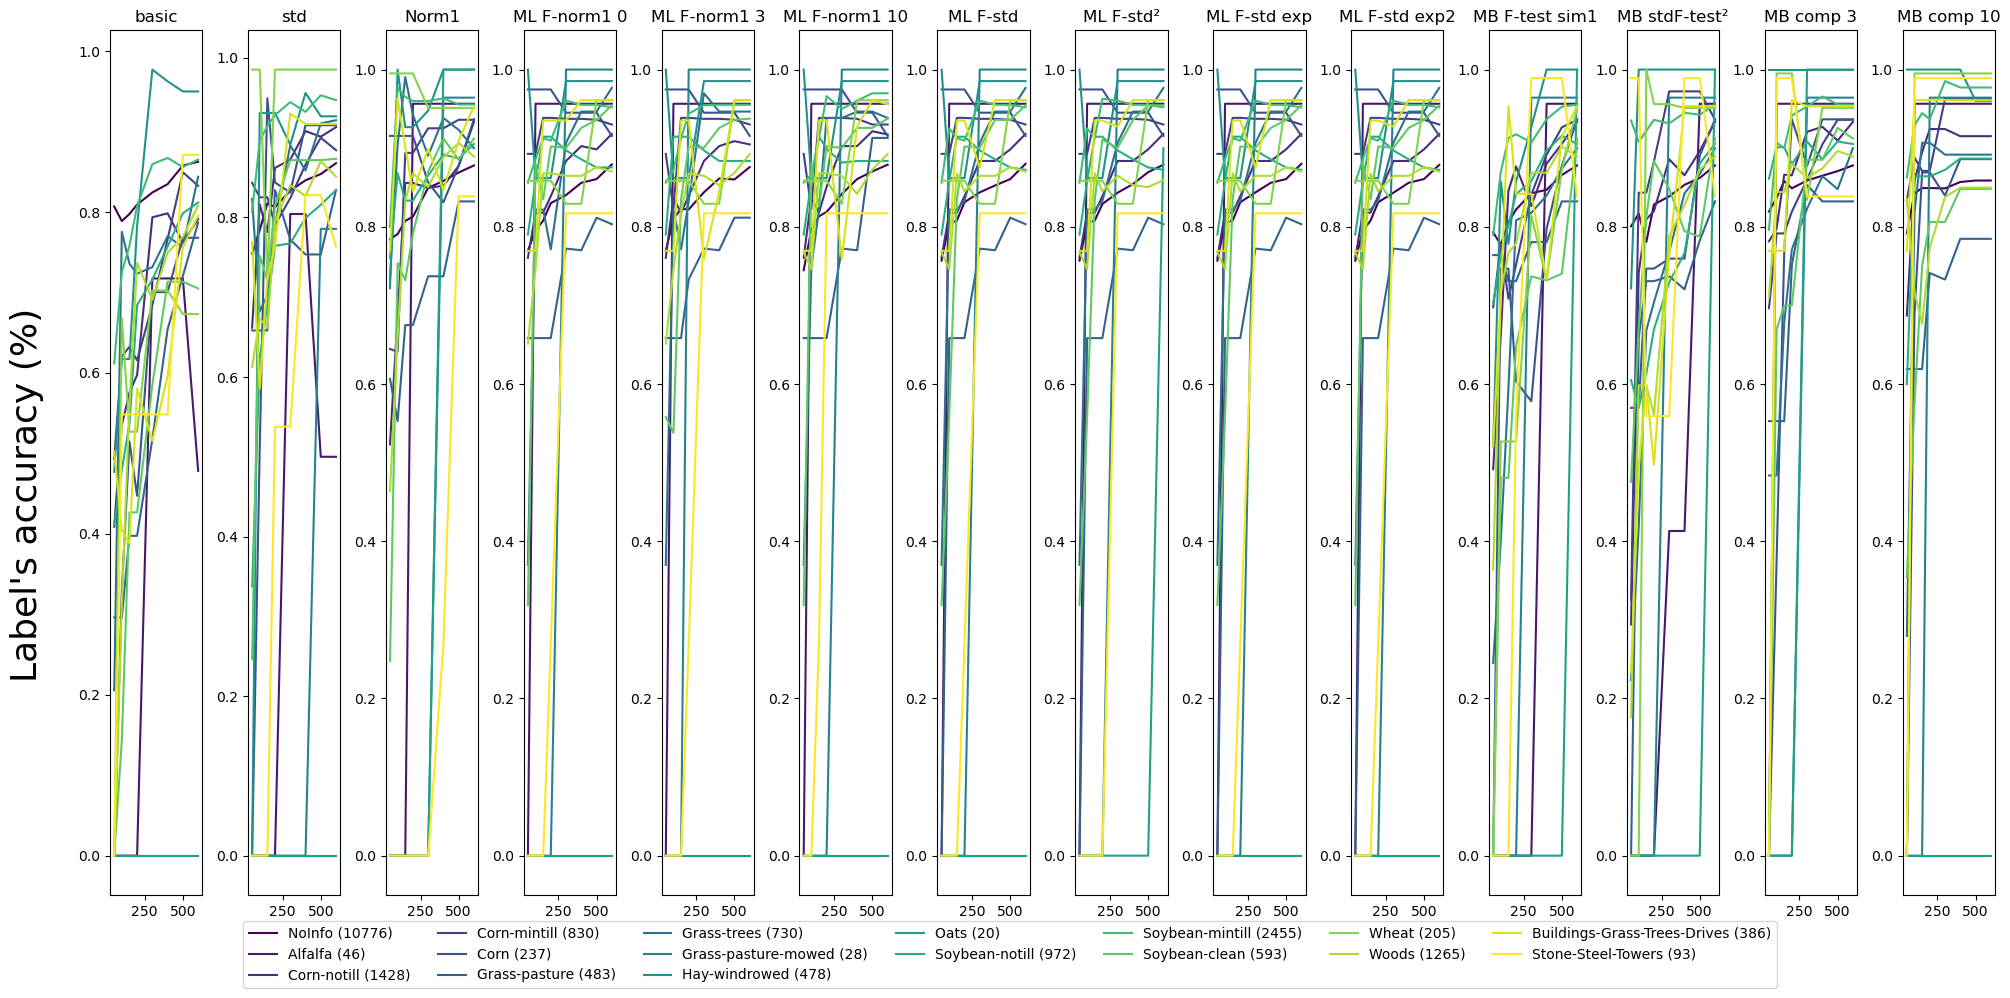

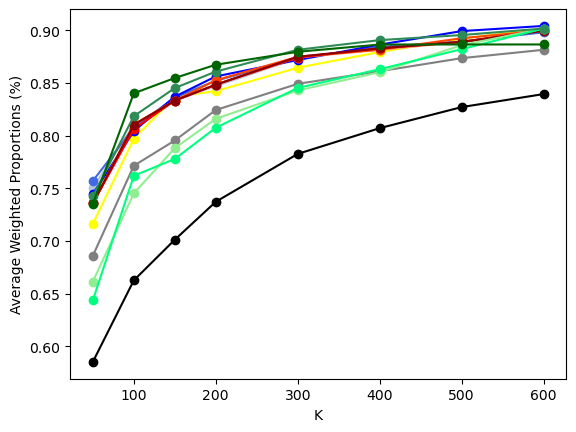

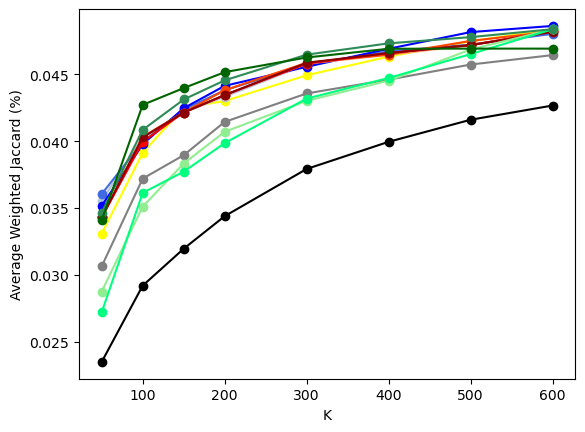

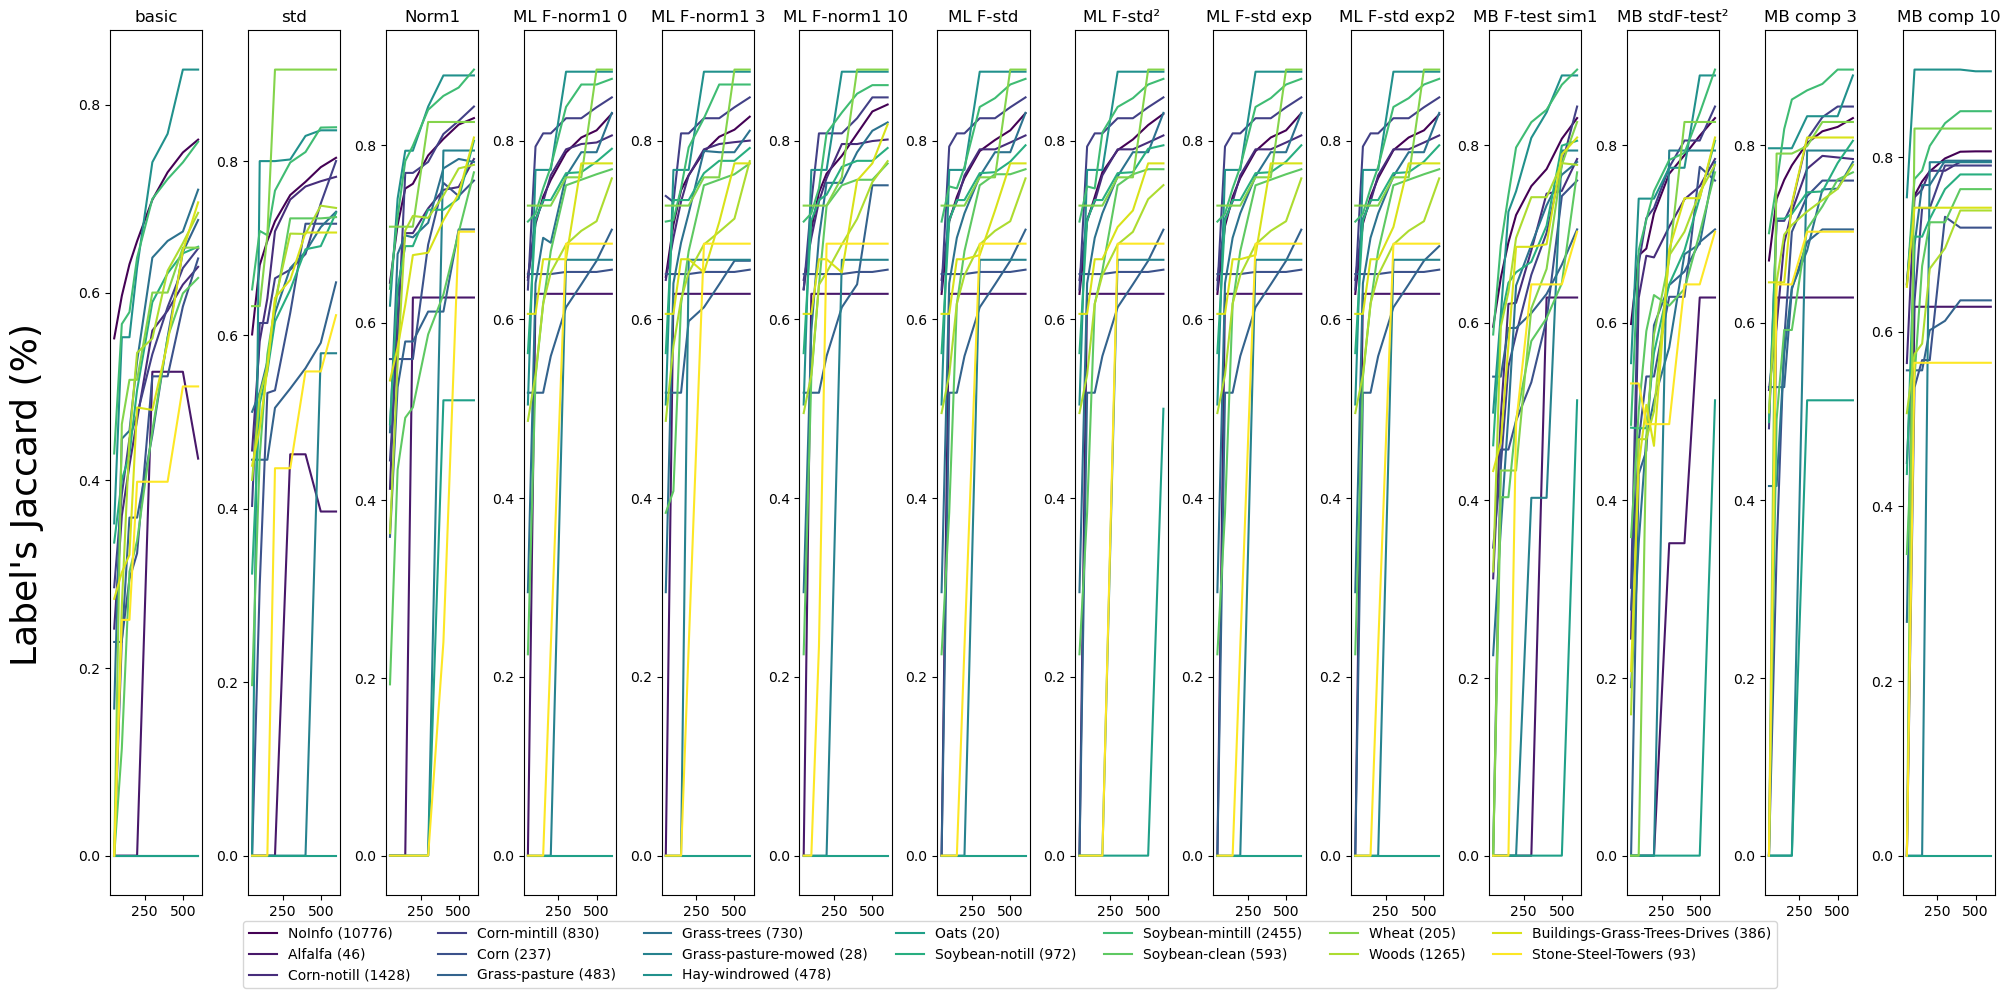

False


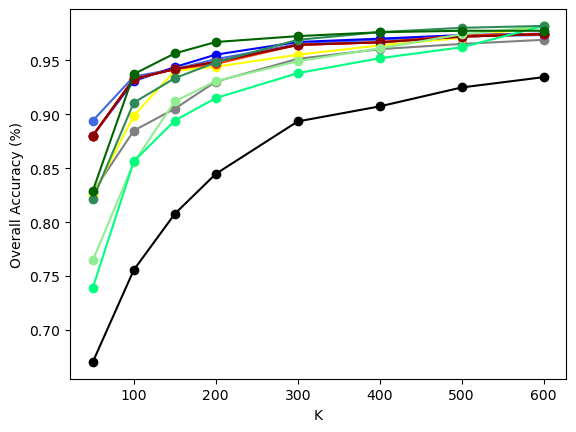

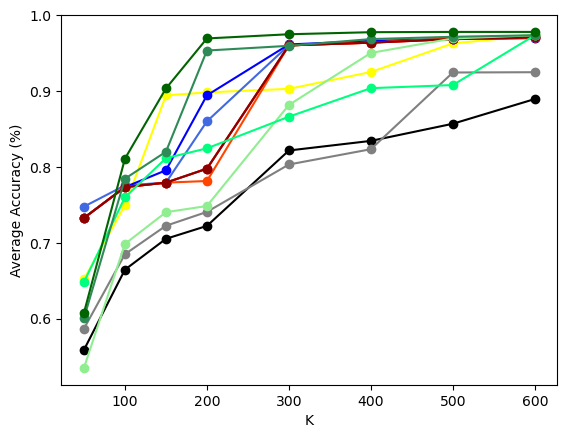

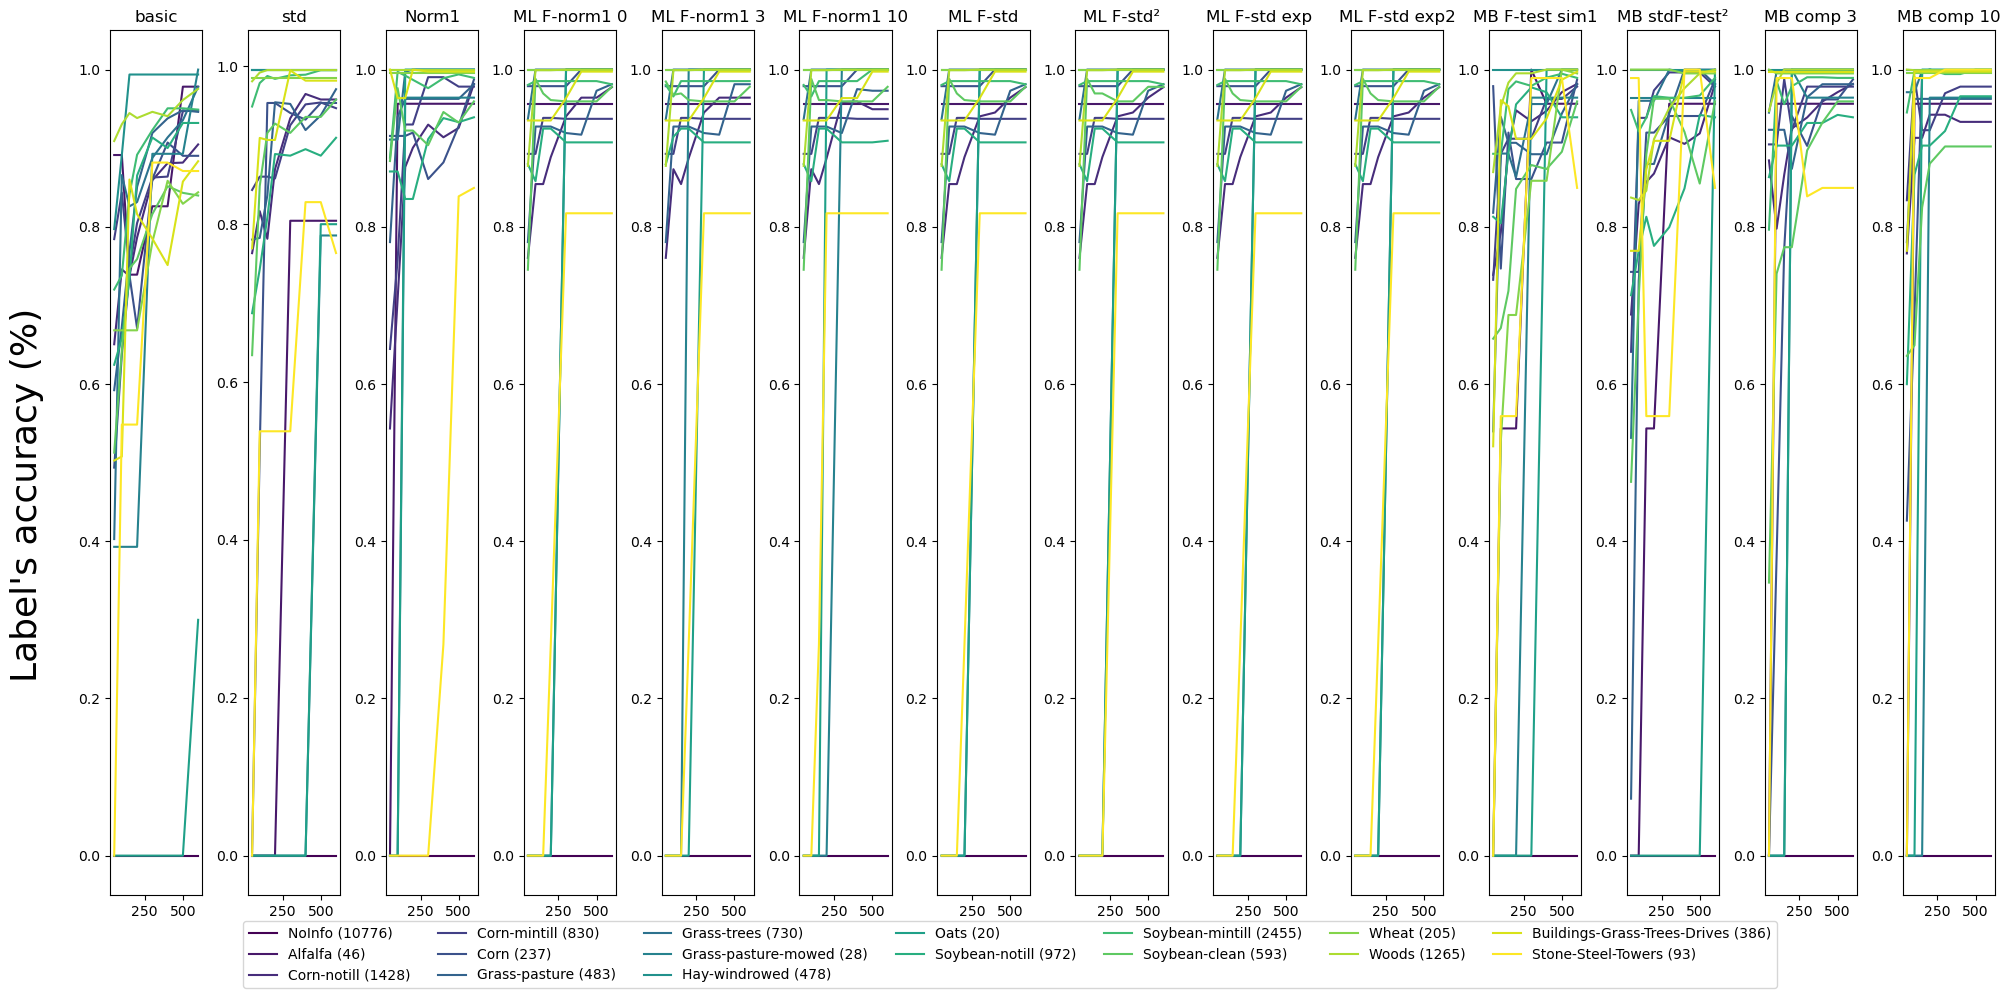

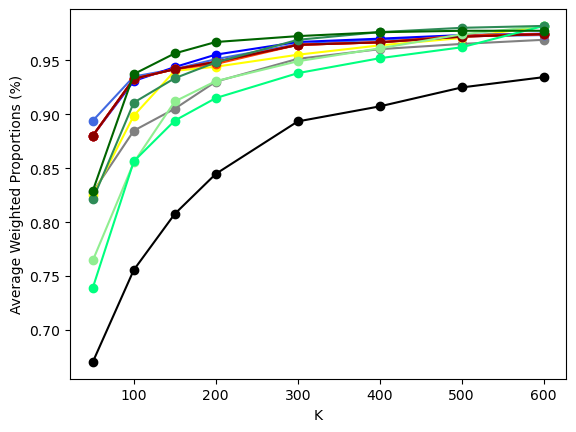

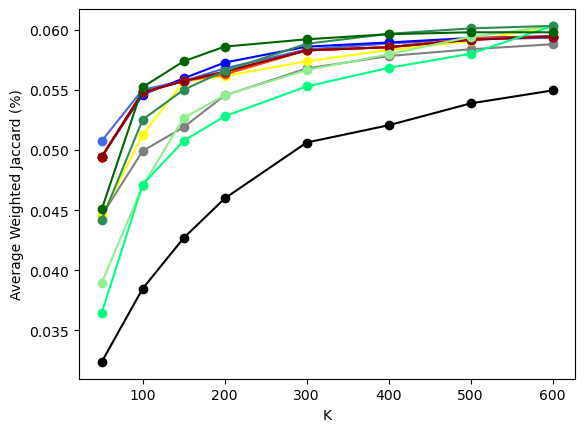

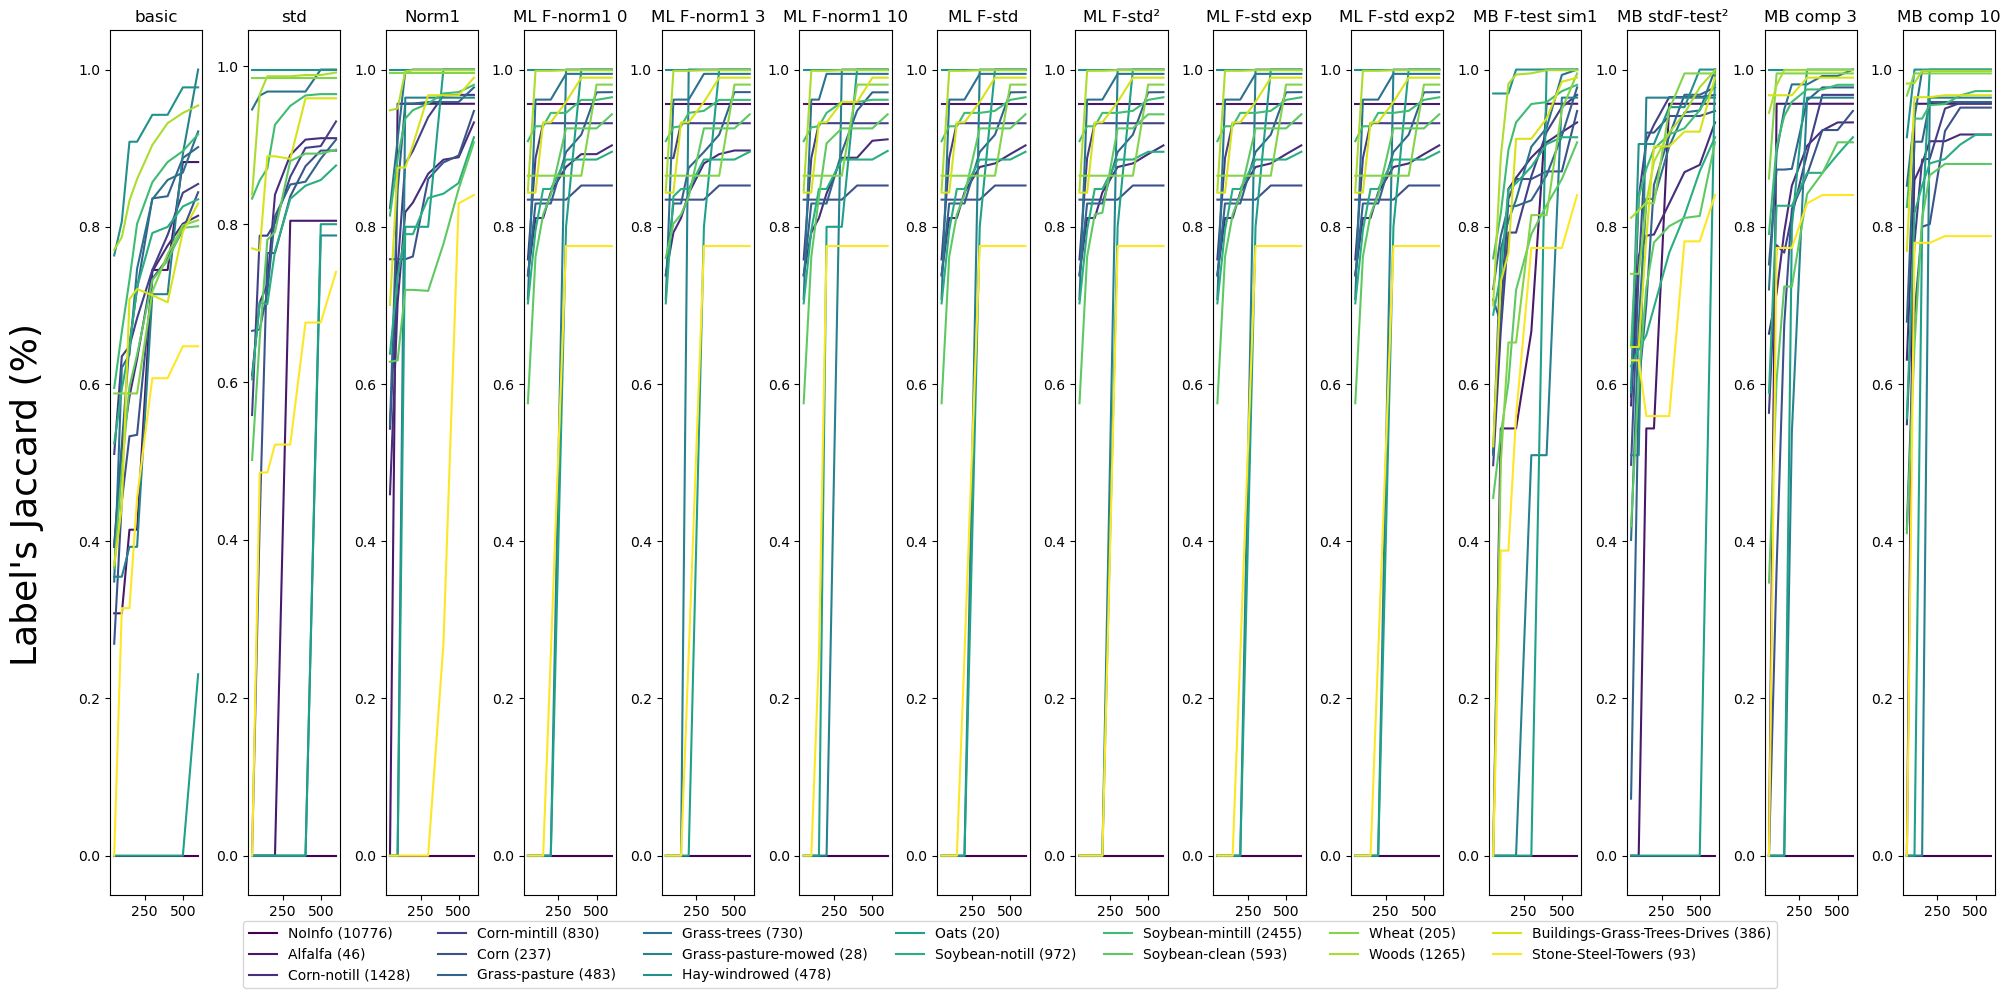

In [ ]:
colors = ["black", "gray", "yellow",
            "lightsteelblue", "royalblue", "blue", 
            "lightsalmon", "orangered", "red", "darkred",
            "lightgreen", "springgreen", "seagreen", "darkgreen",
            "pink", "hotpink", "violet", "mediumprchid"
            ]
#colors = ["orange", "mediumseagreen", "royalblue", "violet", "red"]
def plot_info(info, ylabel="", plotbar=False):
    if plotbar:
        for k,K in enumerate(Ks):
            if K!=50:
                for d in range(size):
                    plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    else:
        length = len(info[Ks[0]])
        for i in range(length):
            plt.plot(Ks, [info[K][i] for K in Ks], "-o", color=colors[i])
            
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()


def plot_label_info(info, ylabel=""):
    fig, axs = plt.subplots(1, len(datas), figsize=(20,10), sharex=True)
    for i in range(len(datas)):
        for label in usedDataset["labels"]:
            if label in info.keys():
                axs[i].plot(Ks, [info[label][K][i] for K in Ks], "-",
                            color=labels_color[label],
                            label=usedDataset["class"][label][0]+" ("+str(len(usedDataset["class"][label][1]))+")")
        axs[i].title.set_text(names[i])
    
    fig.text(0.0, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.0))

    plt.tight_layout()
    plt.subplots_adjust(left=0.05)  
    plt.subplots_adjust(bottom=0.10)
    plt.show()



fig, ax = plt.subplots()
for i in range(len(datas)):
    plt.plot(0,len(datas)-i,"o", color=colors[i], label=names[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(datas), bbox_to_anchor=(0.5, -0.0))

plt.tight_layout()
plt.subplots_adjust(left=0.05)  
plt.subplots_adjust(bottom=0.20)
plt.show()


plotBar = False
motifs = ["-o", "--s", ":^"]
cmap = mpl.colormaps["viridis"]
labels_color = cmap(np.linspace(0, 1, max(usedDataset["labels"])+1))
for b in [True, False]:
    print(b)
    plot_info(overallAccuracys[b], "Overall Accuracy (%)", plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Accuracy (%)", plotbar=plotBar)
    plot_label_info(labelsAccuracy[b], "Label's accuracy (%)")
    #plot_info(singleClassCounts[b], "Unique class proportion (%)", plotbar=plotBar)
    plot_info(averageWeightedProportions[b], "Average Weighted Proportions (%)", plotbar=plotBar)
    plot_info(averageWeightedJaccard[b], "Average Weighted Jaccard (%)", plotbar=plotBar)
    plot_label_info(labelsJaccard[b], "Label's Jaccard (%)")

### GA result

In [ ]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


In [ ]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.IndianPinesMerged["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}

best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}
best_accuracy = {K:[0 for _ in range(len(datas))] for K in Ks}

trainingData = usedDataset["data"]

S_list = {K:[SSGA.compute_Sbsp_Stsp_list(trainData, SPsDic[K][i]) for i in range(len(datas))] for K in Ks}
A = 10
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for a in range(A):
            print(a, end=" ")
            pop, fitness = SSGA.SSGA(trainingData, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2,
                                SP=SPsDic[K][i], S_list=S_list[K][i])
            best_fitness[K][i] += fitness[0]

            bands = pop[0]
            X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
            best_accuracy[K][i] += SVM_accuracy(X_train,y_train, X_test,y_test)

        best_fitness[K][i] /= A
        best_accuracy[K][i] /= A
        print()

K: 50
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
K: 100
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
K: 150
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
K: 200
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3

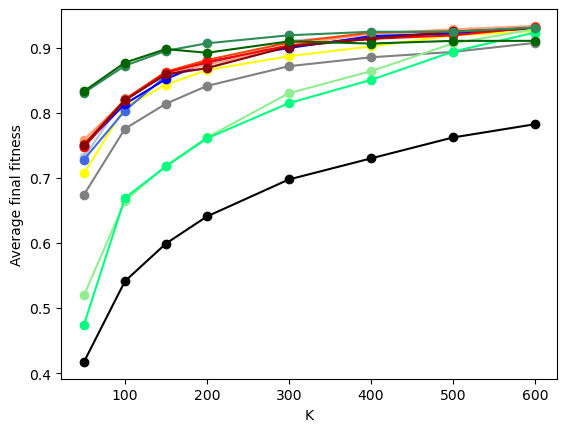

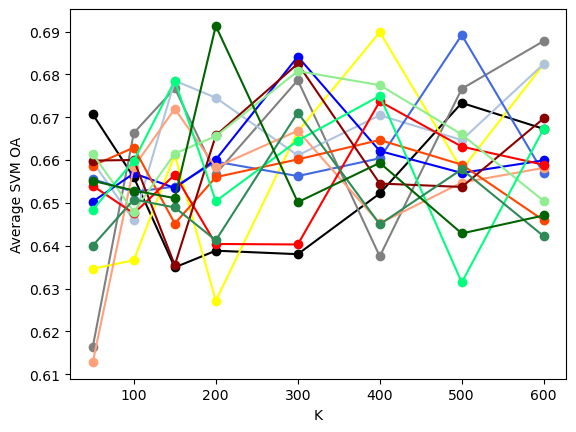

K = 50
[0.6706486042692938, 0.6164408866995075, 0.6346161740558294, 0.6595238095238095, 0.6555316091954022, 0.6502976190476191, 0.6128694581280787, 0.6586925287356322, 0.6539819376026272, 0.6598727422003284, 0.6613711001642035, 0.6483887520525451, 0.6400246305418719, 0.6551518883415435]
K = 100
[0.655952380952381, 0.6663279967159278, 0.6366071428571428, 0.6459051724137932, 0.6525759441707718, 0.656886288998358, 0.6583846469622332, 0.6629002463054187, 0.647536945812808, 0.660016420361248, 0.6479269293924467, 0.6598522167487685, 0.6507697044334975, 0.6528838259441707]
K = 150
[0.6349445812807881, 0.6767446633825943, 0.6612376847290642, 0.6785201149425287, 0.6537972085385879, 0.6534790640394089, 0.6719519704433496, 0.6451662561576355, 0.6565784072249589, 0.6354577175697866, 0.6615147783251232, 0.6785098522167488, 0.6489326765188834, 0.6510981116584565]
K = 200
[0.6388341543513957, 0.6568041871921182, 0.6271346469622332, 0.6745381773399015, 0.6596161740558292, 0.6600882594417078, 0.6583025

In [ ]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_accuracy[K])